In [ ]:
# default_exp nn

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%load_ext tensorboard

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier
import matplotlib.pyplot as plt


In [ ]:
#export
from knowledge_distillation.io import *

In [ ]:
from knowledge_distillation.ensemble import UnbiasedAverage
from knowledge_distillation.processing import * 

/home/jupyterlab/ni-workspace/conda/envs/kd/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [ ]:
import warnings
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=UserWarning)

In [ ]:
# export
import numpy as np
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Embedding
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# Load data

In [ ]:
df = load_adult()

# Preprocessing

In [ ]:
# X, y, target_names = scale_onehot(df, target='salary')


# y = to_categorical(y, max(y) + 1)

X, y, target_names = scale_fastai(df, target='salary')

X_train, X_test, y_train, y_test = split_with_seed(X, y)

In [ ]:
y_train[:5]

array([1, 1, 0, 0, 0], dtype=int8)

# Train a simple fully connected NN

In [ ]:
# export
def create_nn(
    size_layer_1, 
    size_layer_2, 
    size_layer_3, 
    n_class, 
    learning_rate,
    activation='relu', 
    l2=0, 
    dropout=0,
):
    """Keras NN."""
    nn = keras.Sequential()
    nn.add(Dense(size_layer_1))
    nn.add(Activation(activation))
    nn.add(BatchNormalization())
#     nn.add(Dropout(dropout))
    
    nn.add(Dense(size_layer_2))
    nn.add(Activation(activation))
    nn.add(BatchNormalization())
    
    nn.add(Dense(size_layer_3))
    nn.add(Activation(activation))
    nn.add(BatchNormalization())
#     nn.add(Dropout(dropout))
    
    if n_class == 1:
        nn.add(Dense(n_class, activation='sigmoid'))
        loss = 'binary_crossentropy'
    elif n_class == 2:
        nn.add(Dense(n_class, activation='linear'))
        loss = 'binary_crossentropy'
    elif n_class > 2:
        nn.add(Dense(n_class, activation='linear'))
        loss = 'categorical_crossentropy'
    
    nn.compile(loss=loss,
               optimizer=optimizers.Adam(learning_rate=learning_rate),
               metrics=[
                   'accuracy', 
               ]
              )
    return nn



In [ ]:
# export

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
# mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# tensorboard = tf.keras.callbacks.TensorBoard(log_dir='logs/fit', histogram_freq=1)


train_params = {
    "epochs": 15, 
    "batch_size": 1024,
    "validation_split":.3,
    "size_layer_1":200,
    "size_layer_2":100,
    "size_layer_3":50,
    "n_class":1,
    "learning_rate":0.001,
#     "callbacks": [tensorboard]
}

In [ ]:
df.shape

(32561, 15)

In [ ]:
model = KerasClassifier(
    build_fn=create_nn,
    verbose=1,
    **train_params
)

In [ ]:
history = model.fit(X_train, y_train)

Epoch 1/15
18/18 [==============================] - 3s 68ms/step - loss: 0.6619 - accuracy: 0.6523 - val_loss: 4.0410 - val_accuracy: 0.2430
Epoch 2/15
18/18 [==============================] - 1s 44ms/step - loss: 0.4800 - accuracy: 0.7974 - val_loss: 3.6646 - val_accuracy: 0.2520
Epoch 3/15
18/18 [==============================] - 1s 50ms/step - loss: 0.4198 - accuracy: 0.8264 - val_loss: 3.0804 - val_accuracy: 0.2645
Epoch 4/15
18/18 [==============================] - 1s 56ms/step - loss: 0.3809 - accuracy: 0.8427 - val_loss: 2.6848 - val_accuracy: 0.2891
Epoch 5/15
18/18 [==============================] - 1s 55ms/step - loss: 0.3621 - accuracy: 0.8461 - val_loss: 1.6940 - val_accuracy: 0.3011
Epoch 6/15
18/18 [==============================] - 1s 54ms/step - loss: 0.3492 - accuracy: 0.8470 - val_loss: 1.3422 - val_accuracy: 0.3125
Epoch 7/15
18/18 [==============================] - 1s 46ms/step - loss: 0.3365 - accuracy: 0.8533 - val_loss: 0.7632 - val_accuracy: 0.5216
Epoch 8/15
18

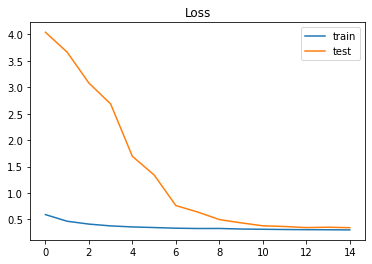

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Loss')
plt.legend();

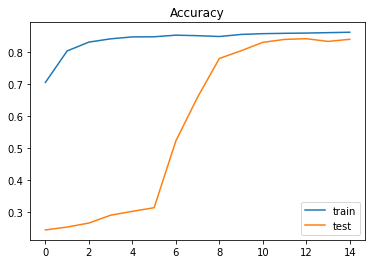

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Accuracy')
plt.legend()

In [ ]:
model.model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 200)               3000      
_________________________________________________________________
activation_14 (Activation)   (None, 200)               0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 200)               800       
_________________________________________________________________
dense_20 (Dense)             (None, 100)               20100     
_________________________________________________________________
activation_15 (Activation)   (None, 100)               0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 100)               400       
_________________________________________________________________
dense_21 (Dense)             (None, 50)               

In [ ]:
# keras.utils.plot_model(model.model, show_shapes=True, dpi=100, rankdir="LR")

In [ ]:
model.predict_proba(X_test.sample(5))

1/1 [==============================] - 0s 224ms/step


array([[0.7708421 , 0.2291579 ],
       [0.01479876, 0.98520124],
       [0.9836832 , 0.0163168 ],
       [0.9718217 , 0.02817827],
       [0.98941123, 0.01058877]], dtype=float32)

# Save model

In [ ]:
# export 

def keras_model_and_classes_paths(name, path=ASSETS_PATH):
    """Get the paths for a keras model and classes"""
    
    model_path = path / f'{name}.tf'
    classes_path = path / f'{name}_classes.pkl'
    return model_path, classes_path

def save_keras_classifier(model, name, path=ASSETS_PATH):
    """Save a Keras model to disk"""
    model_path, classes_path = keras_model_and_classes_paths(name)
    
    pickle.dump(model.classes_, open(classes_path,'wb'))
    model.model.save(model_path)


In [ ]:
save_keras_classifier(model, 'test_keras')

INFO:tensorflow:Assets written to: /home/jupyterlab/ni-workspace/notebooks/notebooks/../assets/test_keras.tf/assets


# Load model

In [ ]:
#export 
def do_nothing():
    return 

def load_keras_classifier(name, path=ASSETS_PATH):
    """Load a Keras model from disk, as KerasClassifier (sklearn wrapper)"""
    model_path, classes_path = keras_model_and_classes_paths(name)
    
    nn = KerasClassifier(build_fn=do_nothing)
    
    # load model and classes
    nn.model = keras.models.load_model(model_path)
    classes = pickle.load(open(classes_path, 'rb'))
    
    # required for sklearn to believe that the model is trained
    nn._estimator_type = "classifier"
    nn.classes_ = classes
    
    return nn


In [ ]:
model = load_keras_classifier(name='test_keras')

# Evaluate single model

In [ ]:
evaluate_model(X_train, X_test, y_train, y_test, model, 'nn', save_to_disk=False, 
               target_names=target_names)

=== Train ===
              precision    recall  f1-score   support

       <=50K       0.86      0.95      0.90     19778
        >50K       0.77      0.52      0.62      6270

    accuracy                           0.85     26048
   macro avg       0.82      0.74      0.76     26048
weighted avg       0.84      0.85      0.84     26048


=== Test ===
              precision    recall  f1-score   support

       <=50K       0.86      0.95      0.90      4942
        >50K       0.76      0.52      0.61      1571

    accuracy                           0.84      6513
   macro avg       0.81      0.73      0.76      6513
weighted avg       0.84      0.84      0.83      6513




,model_name,data,accuracy,precision,recall,f1,auc
0,nn,train,0.847512,0.769592,0.523126,0.622864,0.736737
1,nn,test,0.843237,0.755576,0.517505,0.614280,0.732144


In [ ]:
evaluate_model(X_train, X_test, y_train, y_test, model, 'nn', save_to_disk=False, 
               target_names=target_names)

=== Train ===
              precision    recall  f1-score   support

       <=50K       0.86      0.95      0.90     19778
        >50K       0.77      0.52      0.62      6270

    accuracy                           0.85     26048
   macro avg       0.82      0.74      0.76     26048
weighted avg       0.84      0.85      0.84     26048


=== Test ===
              precision    recall  f1-score   support

       <=50K       0.86      0.95      0.90      4942
        >50K       0.76      0.52      0.61      1571

    accuracy                           0.84      6513
   macro avg       0.81      0.73      0.76      6513
weighted avg       0.84      0.84      0.83      6513




,model_name,data,accuracy,precision,recall,f1,auc
0,nn,train,0.847512,0.769592,0.523126,0.622864,0.736737
1,nn,test,0.843237,0.755576,0.517505,0.614280,0.732144


In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 00_io.ipynb.
Converted 01_processing.ipynb.
Converted 02_ensemble.ipynb.
Converted 03a_logistic.ipynb.
Converted 03b_NN.ipynb.
Converted 03c_bag_of_trees.ipynb.
Converted 04_train_NN.ipynb.
Converted 05_train_multiple_NNs.ipynb.
Converted 05a_train_identical_seed.ipynb.
Converted 06_NN_ensemble.ipynb.
Converted 07_distill_multiple_NNs.ipynb.
Converted 07a_train_and_distill_multiple_NNs.ipynb.
Converted 08_compare.ipynb.
Converted index.ipynb.
